In [1]:
%load_ext autoreload
%autoreload 2
!hostname
!pwd
import os, sys
print(sys.executable)
os.environ['CUDA_VISIBLE_DEVICES'] = "7"

fish-gcp005
/home/akarshkumar0101/nca-alife/src
/home/akarshkumar0101/miniconda3/envs/nca-alife-jax/bin/python


In [2]:
import os, sys, glob, pickle
from functools import partial

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from tqdm.auto import tqdm
from einops import rearrange, reduce, repeat

In [3]:
import experiment_utils
import util

In [36]:
from imax import transforms, color_transforms, randaugment

In [6]:
import jax
import jax.numpy as jnp
from jax.random import split

import flax
import flax.linen as nn
from flax.training.train_state import TrainState

import optax

In [7]:
rng = jax.random.PRNGKey(0)

2024-06-20 19:33:26.829487: W external/xla/xla/service/gpu/nvptx_compiler.cc:763] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [31]:
img = plt.imread('../img.jpg')/255.
img = jax.image.resize(img, (224, 224, 3), method='bilinear').clip(0, 1)

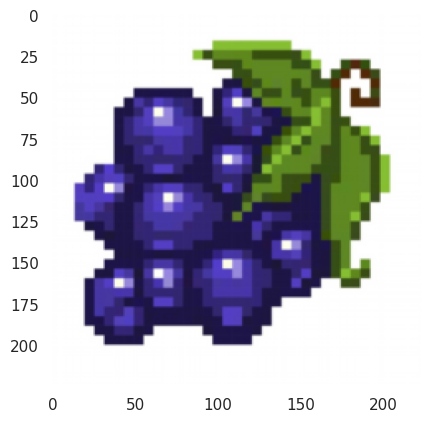

In [33]:
plt.imshow(img)
plt.grid(False)

In [ ]:

def random_perspective(_rng, img, distortion_scale=0.5):
    import random
    height, width = img.shape[0], img.shape[1]
    
    # Randomly determine the scale factors based on the distortion scale
    max_dx = distortion_scale * width / 2
    max_dy = distortion_scale * height / 2
    
    # Randomly select translation factors
    dx = random.uniform(-max_dx, max_dx)
    dy = random.uniform(-max_dy, max_dy)
    
    # Randomly select shear factors
    max_shear = distortion_scale * 0.5
    h_shear = random.uniform(-max_shear, max_shear)
    v_shear = random.uniform(-max_shear, max_shear)
    
    # Perform transformations
    # transformed_img = translate(img, horizontal=dx, vertical=dy)
    transform = transforms.translate(dx, dy)
    img = transforms.apply_transform(img, transform, mask_value=-0.)
    
    # img = shear(transformed_img, horizontal=h_shear, vertical=v_shear)
    transform = transforms.shear(h_shear, v_shear)
    img = transforms.apply_transform(img, transform, mask_value=-0.)
    return img

In [252]:
def augment_img(_rng, img):
    # transform = transforms.rotate(rad=0.7)
    # img = transforms.apply_transform(img, transform, mask_value=-0.)
    
    # transform = transforms.translate(50, 50)
    # img = transforms.apply_transform(img, transform, mask_value=-0.)

    # transform = transforms.scale(2.0, 2.0)
    # img = transforms.apply_transform(img, transform, mask_value=-0.)
    
    # transform = transforms.shear(2.0, 0.)
    # img = transforms.apply_transform(img, transform, mask_value=-0.)

    _rng1, _rng2, _rng3, _rng4 = split(_rng, 4)

    sx, sy = jax.random.uniform(_rng1, (2, ), minval=0.9, maxval=1.5)
    Ms = transforms.scale(sx, sx)
    
    shx, shy = jax.random.uniform(_rng2, (2, ), minval=-.5, maxval=.5)
    Msh = transforms.shear(shx, shy)
    
    r = jax.random.uniform(_rng3, (), minval=-jnp.pi/4, maxval=jnp.pi/4)
    Mr = transforms.rotate(r)

    H, W, D = img.shape
    tx, ty = jax.random.uniform(_rng4, (2, ), minval=-H/4, maxval=H/4)
    Mt = transforms.translate(tx, ty)

    M = Mt@Mr@Msh@Ms
    
    return transforms.apply_transform(img, M, mask_value=-0.)

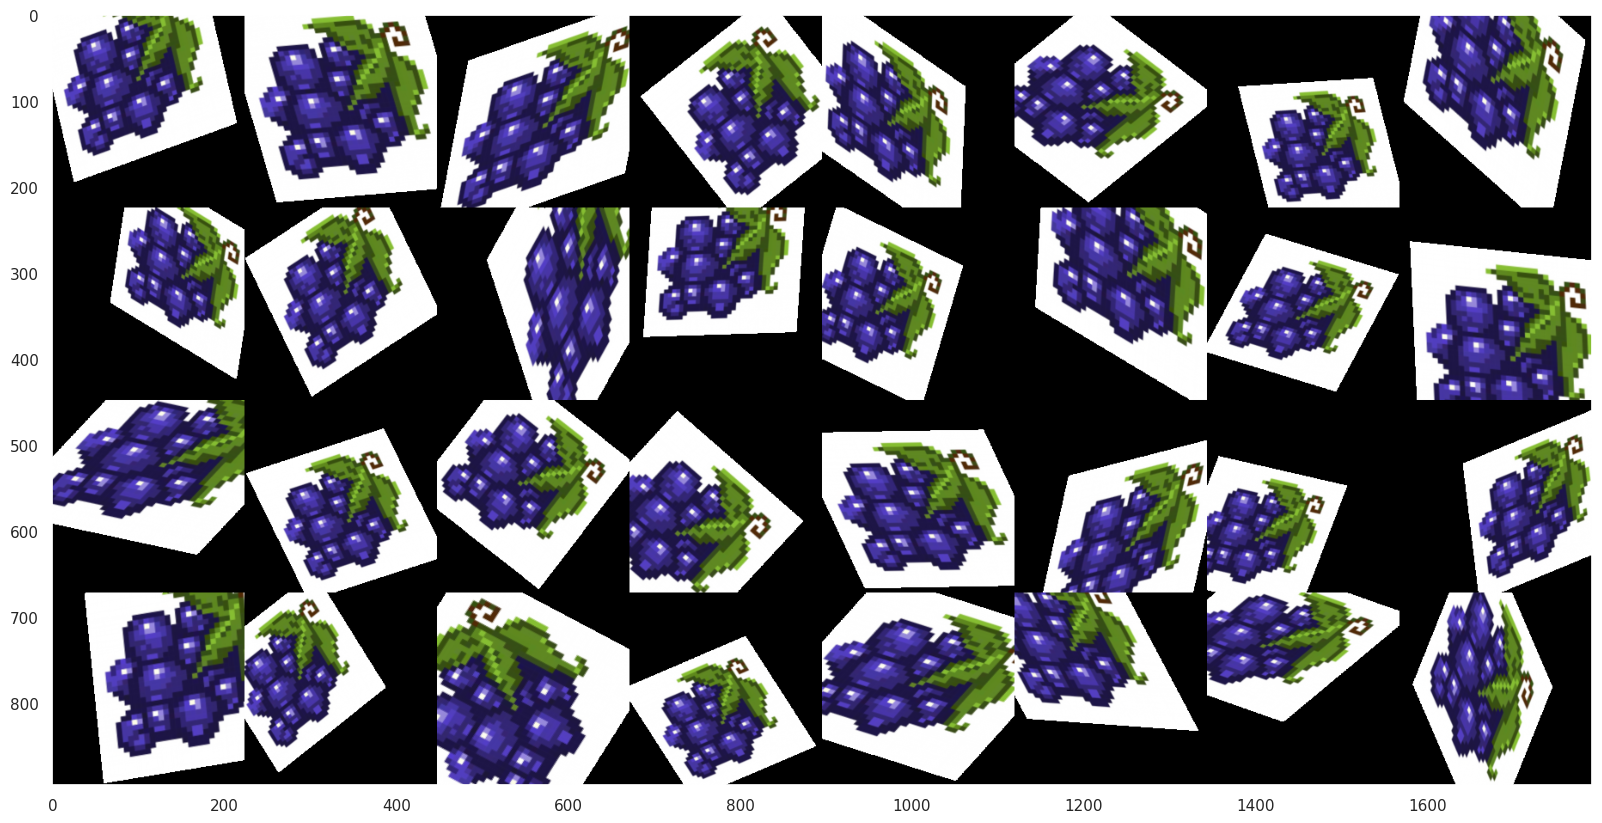

In [253]:
imgp = jax.vmap(augment_img, in_axes=(0, None))(split(rng, 32), img)

plt.figure(figsize=(20, 10))
a = rearrange(imgp, "(R C) H W D -> (R H) (C W) D", R=4).clip(0, 1)
plt.imshow(a)
plt.grid(False)
plt.show()

In [284]:
def loss_fn(img):
    imgp = jax.vmap(augment_img, in_axes=(0, None))(split(rng, 1), img)
    return imgp.mean()

loss, a = jax.value_and_grad(loss_fn)(img)


In [285]:
a.shape

(224, 224, 3)

In [294]:
(jnp.isnan(a[:, :, 0])).sum()

Array(12, dtype=int32)

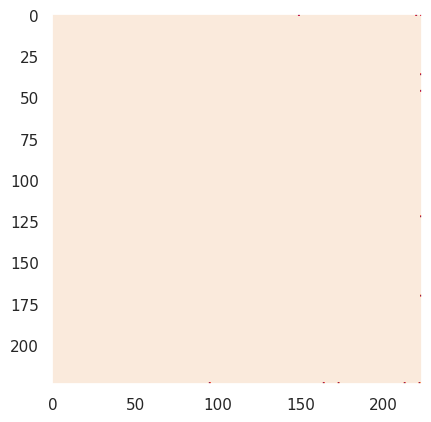

In [295]:
plt.imshow(~jnp.isnan(a[:, :, 0]))
plt.grid(False)

-0.0 1.0000001 (224, 224, 3)


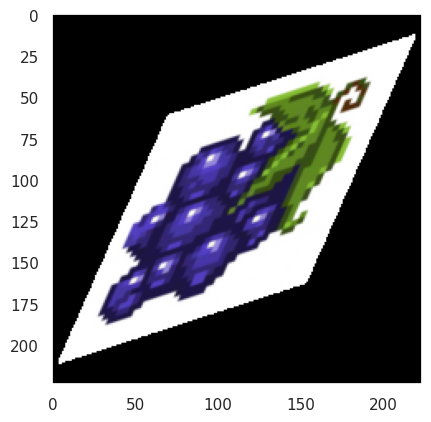

In [183]:
imgp = augment_img(rng, img)
print(imgp.min(), imgp.max(), imgp.shape)
plt.imshow(imgp.clip(0, 1))
plt.grid(False)
plt.show()

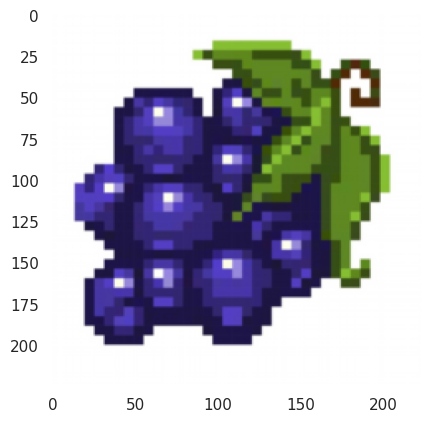

In [117]:
plt.imshow(img.clip(0, 1))
plt.grid(False)
plt.show()